<a href="https://colab.research.google.com/github/Aman-Kr-Gupta/Surface_Bridge_crack_detection/blob/main/MobileNetV3_Large_surafce_bridge_crack_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
train_dir = os.path.join('/content/drive/MyDrive/Crack_detection_DB/train')
validation_dir = os.path.join('/content/drive/MyDrive/Crack_detection_DB/valid')
test_dir = os.path.join('/content/drive/MyDrive/Crack_detection_DB/test')

BATCH_SIZE = 16
IMG_SIZE = (160,160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 628 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 208 files belonging to 2 classes.


In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 200 files belonging to 2 classes.


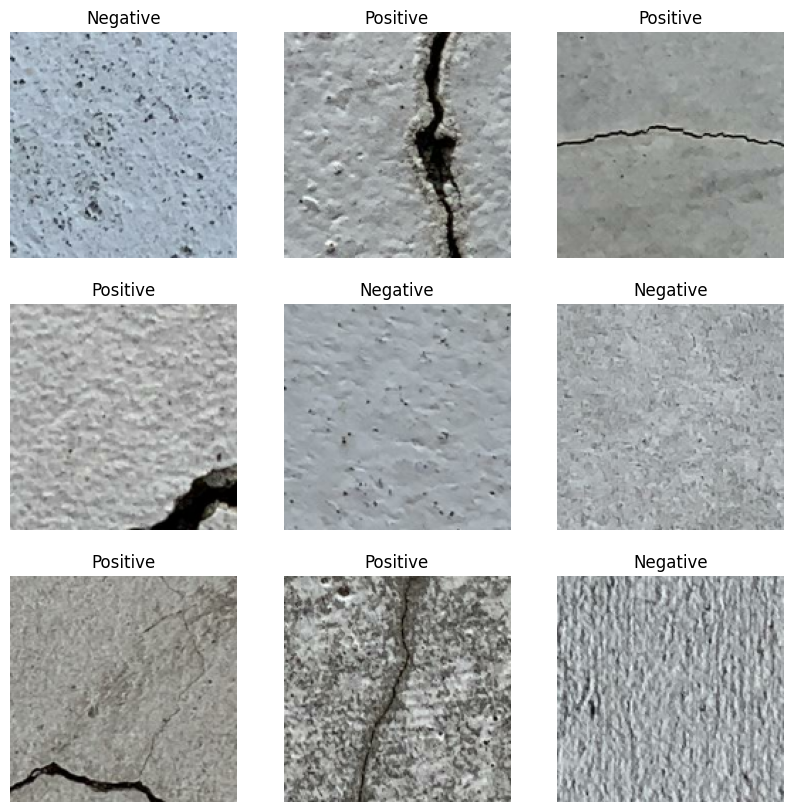

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 13
Number of test batches: 13


# Configure Dataset Performance and Data Augumentation


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

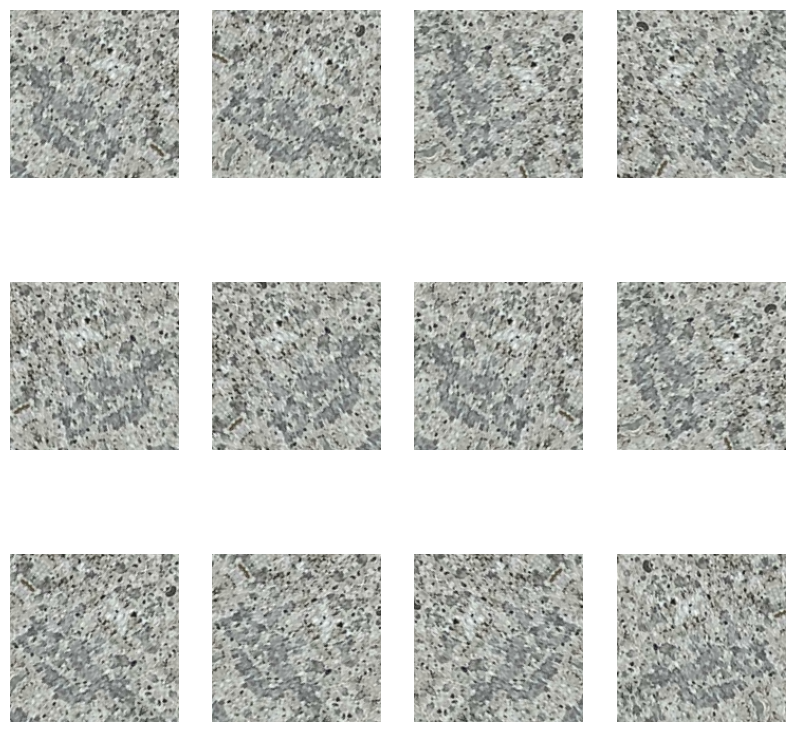

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

12683000/12683000 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 5, 5, 960)


In [ ]:

base_model.trainable=False

In [ ]:
base_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 80, 80, 16)   432         ['rescaling_1[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 80, 80, 16)  64          ['Conv[0][0]']    

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 960)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160,160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

2

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 5, 5, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 1)                 961   

In [ ]:
initial_epochs = 100

loss0, accuracy0 = model.evaluate(validation_dataset)

13/13 [==============================] - 36s 920ms/step - loss: 1.3675 - accuracy: 0.4087


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.37
initial accuracy: 0.41


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/100
40/40 [==============================] - 52s 1s/step - loss: 1.1710 - accuracy: 0.3551 - val_loss: 1.1566 - val_accuracy: 0.4423
Epoch 2/100
40/40 [==============================] - 20s 497ms/step - loss: 1.0233 - accuracy: 0.4013 - val_loss: 0.9838 - val_accuracy: 0.5096
Epoch 3/100
40/40 [==============================] - 28s 694ms/step - loss: 0.9070 - accuracy: 0.4411 - val_loss: 0.8413 - val_accuracy: 0.5385
Epoch 4/100
40/40 [==============================] - 23s 570ms/step - loss: 0.7913 - accuracy: 0.5446 - val_loss: 0.7255 - val_accuracy: 0.5962
Epoch 5/100
40/40 [==============================] - 20s 493ms/step - loss: 0.7438 - accuracy: 0.5525 - val_loss: 0.6247 - val_accuracy: 0.6923
Epoch 6/100
40/40 [==============================] - 25s 623ms/step - loss: 0.6414 - accuracy: 0.6752 - val_loss: 0.5470 - val_accuracy: 0.7548
Epoch 7/100
40/40 [==============================] - 18s 445ms/step - loss: 0.6116 - accuracy: 0.6863 - val_loss: 0.4797 - val_accuracy: 0.

In [ ]:
model.save('/content/drive/MyDrive/Crack_detection_DB/modelv3.h5')

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

13/13 [==============================] - 28s 737ms/step - loss: 0.1807 - accuracy: 0.9850
Test accuracy : 0.9850000143051147


Predictions:
 [0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1]
Labels:
 [0 1 1 1 0 1 1 0 0 1 0 0 0 1 0 1]


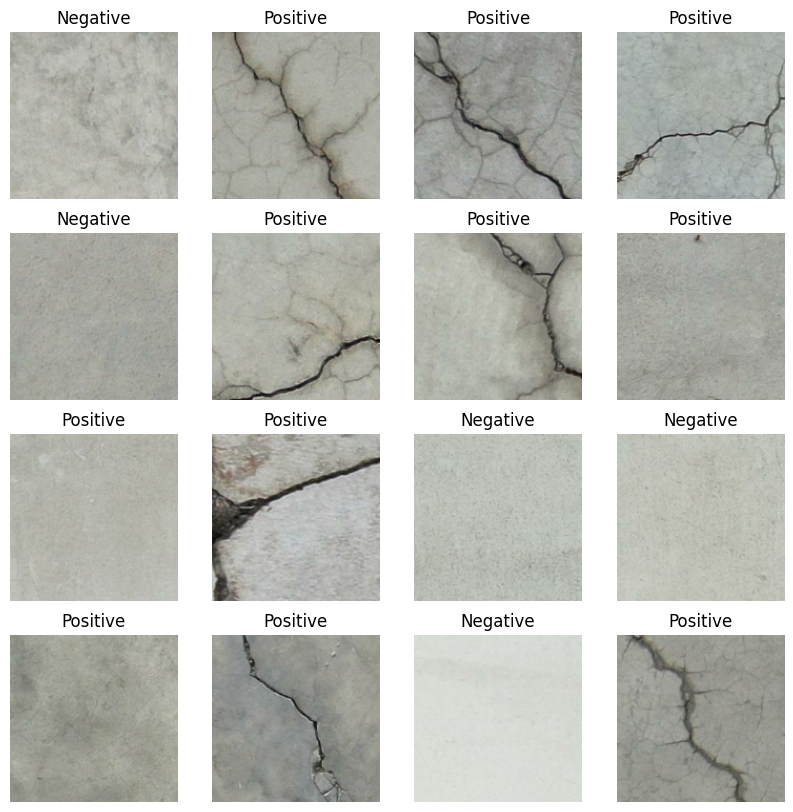

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")